## Introduction:  Project 11
This notebook creates vacation brochures for 3 destinations across the Universe based on estimated flight distance & time from Earth, temperature, and atmosphere. We will have a list of 8 possible stars and planets you can visit while utilizing LLM API calls to generate 3 activites, cost, and a sentence brief description. Each brochure contains the destination name, description of destination that is stored as an attribute of the SpaceDestination class, specs (distance, travel time, etc), and a cheap and expensive version of activities as well as a cost estimate.


In [112]:
# pip installs and dependencies
%pip install openai anthropic python-dotenv matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


**Set up**
--

Download required libraries, initilize API key, and set up claude client for LLM API calls. 
This involves securing the API credentials from a .env file and creating the client object for the Anthropic service. The use of environment variables is best practice to prevent hardcoding sensitive API keys directly into the notebook. The client object, initialized with the API key, is what enables the notebook to communicate with the LLM model to generate content for the brochures. Error handling is a key feature here, ensuring that if the API key is missing, the script does not immediately fail, though the LLM functionality would be disabled.



In [113]:
#imports
from openai import OpenAI
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

# Load environment variables from the .env file
load_dotenv()

#claude api
from anthropic import Anthropic

claude_api_key = os.getenv("ANTHROPIC_API_KEY")
client = Anthropic(api_key=claude_api_key) if claude_api_key else None

**Class Initialization for SpaceDestination and TourPackage**
--

This code block initializes classes to create objects for each SpaceDestination that we'll offer, for each activity that the LLM will help generate, and the complete TourPackage. We've enhanced the technical depth by adding the cost_per_au metric to the TourPackage and introducing the TourComparisonTool class to perform cross-package analysis. We've included all calculations of cost and distance in these classes as well.

---

SpaceDestination
- Name: string
- Distance: float (furtherest astronomical unit from Earth)
- Cost: $100 * (astronomical units)
- Description: short paragraph

Activity
- generated by LLM API call

TourPackage
- Destination: SpaceDestination object
- Activity 1: Activity object
- Activitiy 2: Activity object
- Activity 3: Activity object

TourComparisonTool 
- Purpose: Compares all generated TourPackage objects. 
- Functionality: Identifies the single most cost-efficient package based on the cost_per_au metric, demonstrating critical data analysis across object instances.

In [114]:
class SpaceDestination:
    """
    Represents a potential space travel destination, calculating the base
    travel cost from its distance.
    """
    def __init__(self, name, distance, description):
        """
        Initializes a SpaceDestination object.

        :param name: The name of the celestial body (string).
        :param distance: The distance from Earth in Astronomical Units (float).
        :param description: A short descriptive paragraph about the destination (string).
        """
        self.name = name
        self.distance = distance
        self.cost = round(100 * float(distance), 2)
        self.description = description

    def __str__(self):
        return f"Travel to {self.name} Base Cost: ${self.cost}\tDistance:{self.distance} AU\n{self.description}\n\n"

class Activity:
    """
    Represents a single activity at a destination, typically generated by an LLM.
    """
    def __init__(self, name, cost, description):
        """
        Initializes an Activity object.

        :param name: The name of the activity (string).
        :param cost: The estimated dollar cost of the activity (float).
        :param description: A brief description of the activity (string).
        """
        self.name = name
        self.cost = cost
        self.description = description
    def __str__(self):
        return f"{self.name}\n\nCost: ${self.cost}\n{self.description}"

class TourPackage:
    """
    Aggregates a SpaceDestination and three Activities into a complete tour package.
    Calculates the total cost of the package, and the new cost-per-AU metric.
    """
    def __init__(self, dest, act1, act2, act3):
        
        # === CRITICAL FIX: These lines must come first! ===
        self.dest = dest
        self.act1 = act1
        self.act2 = act2
        self.act3 = act3
        # ===================================================
        
        # Now these calculations can safely access self.dest, self.act1, etc.
        self.total_cost = round(float(dest.cost) + float(act1.cost) + float(act2.cost) + float(act3.cost), 2)
        
        # This line must be present and executed!
        if self.dest.distance == 0:
             self.cost_per_au = 0.0
        else:
             self.cost_per_au = round(self.total_cost / self.dest.distance, 2)
    
    def __str__(self):
        # The rest of the __str__ method remains the same and is correct
        return (f"Activity 1: {self.act1}"
        f"\n\nActivity 2: {self.act2}"
        f"\n\nActivity 3: {self.act3}\n"
        "--------------------------------------------------------------------------------------------------"
        f"\nTotal Costs (Travel + Activities): ${self.total_cost}"
        f"\nCost Efficiency (Total Cost per AU): ${self.cost_per_au}")

class TourComparisonTool:
    """
    A new class for added technical depth. It's designed to perform analysis
    and present insights across multiple TourPackage objects.
    """
    def __init__(self, tour_packages):
        self.packages = tour_packages

    def find_most_cost_efficient(self):
        """
        Identifies and returns the package with the lowest cost-per-AU.
        Demonstrates use of object attributes for analysis.
        """
        if not self.packages:
            # Added more descriptive error handling
            return "Error: No tour packages were created. Please check LLM generation and make_brochure calls."
            
        most_efficient_pkg = min(self.packages, key=lambda pkg: pkg.cost_per_au)
        
        return (f"Most Cost-Efficient Tour: {most_efficient_pkg.dest.name} "
                f"at ${most_efficient_pkg.cost_per_au} per AU.\n"
                f"Total Package Cost: ${most_efficient_pkg.total_cost}")

**Our "database" of possible travel destinations**
--

Not generated with LLM API due to cost constraints.

---

This list represents the initial data set for the project. These 8 destinations were not generated with the LLM API to ensure a fixed starting point and to control the input data for the LLM's selection process, which is an important constraint for cost-effectiveness in development. The selection covers a diverse range of celestial bodies, from the rocky inner planets (Mercury, Mars) to the gas giants (Jupiter, Saturn, Uranus) and the distant dwarf planets (Pluto, Ceres, Orcus). The distances are approximated and stated in Astronomical Units (AU). The LLM's task is to filter this list of 8 down to the 3 most relevant destinations based on the user's input goals.

In [115]:
#List of 8 chooseable destinations, hardcoded in
#includes name, distance, description in the arguments
locations = []
locations.append(SpaceDestination("Mars", 2.5, "Desert-like rocky planet with a tenuous atmosphere."))
locations.append(SpaceDestination("Jupiter", 6.2, "Gas giant known for its colorful, swirling cloud bands and the Great Red Spot"))
locations.append(SpaceDestination("Uranus", 20.1, "Cold, blue-green, ice giant"))
locations.append(SpaceDestination("Pluto", 50, "Dwarf planet in the Kuiper Belt featuring varied terrain"))
locations.append(SpaceDestination("Mercury", 1.45, "Features a rocky surface, a large iron core, and extreme temperature variations"))
locations.append(SpaceDestination("Saturn", 10.07, "Gas giant with a prominent ring system made of ice and dust and massive gaseous atmosphere"))
locations.append(SpaceDestination("Ceres", 3.1, "Dwarf planet known for its high water ice content,"))
locations.append(SpaceDestination("Orcus", 48.91, "Dwarf planet in the Kuiper Belt rich in crystalline water ice"))

 **LLM integration**
 --

Use LLM API call to:

---

1. Determine which 3 destinations to make a tour package for based on input from user goals.
    - Prompt asks for list of 3 destinations from already made list of 8
    - Our idea is for LLM to determine which fits best based on general knowledge of each location since this should be abstract
2. Use LLM API call to generate activities based on user goals.
    - Prompt asks for list of 3 activities for each destination based on small amount of provided info
    - Our idea is for LLM to determine which fits best based on general knowledge since we wanted a non realistic approach.
- We tried to incorporate few shot prompting and structured LLM prompting to get a creative yet properly formatted LLM output each time.


In [116]:
def llm_pick_destinations(user_goals, available_destinations):
    """
    Uses the Claude LLM API to select 3 destinations that best match the user's goals
    from a list of available destinations.

    :param user_goals: A string defining the user's travel goals/constraints.
    :param available_destinations: A list of SpaceDestination objects to choose from.
    :return: A string containing the names of the 3 selected destinations, separated by commas.
    """ 

    #error handling with try, except 
    try: 
        response = client.messages.create( 
            model="claude-sonnet-4-20250514", 
            messages=[{"role": "user", 
                       "content": f"From these destinations: {[d.name for d in available_destinations]}, pick 3 that best match these goals: '{user_goals}'. Reply only with: [choice 1], [choice 2], [choice 3]."}], 
            max_tokens=40, 
        ) 
        return response.content[0].text.strip() 
    except: 
        # In case call fails, return these three. 
        return "Mars, Jupiter, Saturn" 
    

# prompts the LLM to generate activities based on user goals
def llm_generate_activities(destination, user_goals, distance, cost):
    """
    Uses the Claude LLM API to generate 3 unique activities, their costs,
    and descriptions for a specific destination based on user goals,
    using a few-shot example for format consistency.
    """
    # System message: Sets the context and rule-following expectations
    system_message = (
        "You are a creative space tourism brochure generator. Your only task "
        "is to generate exactly 3 unique, whimsical, and creative space tourism activities. "
        "You MUST STRICTLY adhere to the requested EXACT output format, including the '###' separator and the pipeline '|'."
    )
    
    # Few-Shot Example: Provides a clear, correct example of the desired output format
    few_shot_example = (
        "Activity 1: Zero-G Jousting Tournament | 150.0 | Participate in a weightless jousting match using foam lances and magnetically-cushioned hover platforms. It's a fun, family-friendly competition with minor tumbles guaranteed."
        "\n###\n"
        "Activity 2: Deep Space Stargazing Retreat | 250.5 | Spend a night in a transparent, climate-controlled bubble to witness galaxies unmarred by any planetary atmosphere. A professional astronomer will guide you through the cosmos."
        "\n###\n"
        "Activity 3: Alien Cuisine Tasting Menu | 90.0 | Sample synthetically-grown, delicious dishes inspired by the local celestial body's elemental composition. All ingredients are safe and surprisingly flavorful."
    )
    
    # User message: The actual request to the LLM
    user_prompt = (
        f"Generate exactly 3 creative unique space tourism activities for {destination}. "
        f"User goals: {user_goals}. Budget (Travel Base Cost): ${cost}. "
        f"Your output MUST match the format of the example provided. Ensure each cost is a float."
    )
    
    try:
        response = client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=350,  
            temperature=0.7, # Increased temperature for more creative output
            system=system_message, # Set the system message
            messages=[
                {"role": "user", "content": f"Example Output Format:\n{few_shot_example}"}, # New: Few-shot example
                {"role": "assistant", "content": few_shot_example}, # New: Few-shot example
                {"role": "user", "content": user_prompt} # Final prompt
            ]
        )
        activities_text = response.content[0].text
        print(activities_text)
        return activities_text
    except Exception as e:
        print(f"Claude API error: {e}")
        # Default with costs calculated directly to avoid errors if API fails
        cost_base = cost 
        return (
            f"Activity 1: Surface Walk | {round(cost_base * 0.3, 2)} | Explore {destination} terrain for half a day.\n###\n"
            f"Activity 2: Photo Session | {round(cost_base * 0.4, 2)} | Capture {destination} views at the highest peak.\n###\n"
            f"Activity 3: Orbital Tour | {round(cost_base * 0.3, 2)} | See {destination} from a low orbit shuttle."
        )

1. Prompt user for input.
2. Make API call to LLM to gather 3 locations based off user input.
3. Return list of SpaceDestination objects associated with given destinations.


In [117]:
# User input for goals/constraints.
print("Welcome to Space Tourism!")
print("What are your goals/constraints? (e.g., 'budget-friendly', 'luxury experience', 'adventure', 'relaxation')")
user_goals = input("Your goals: ").strip()

# LLM picks 3 destinations from your 8 options. call llm_pick_destinations function created above
selected_names = llm_pick_destinations(user_goals, locations)
selected_destinations = [dest for dest in locations if dest.name in selected_names]

Welcome to Space Tourism!
What are your goals/constraints? (e.g., 'budget-friendly', 'luxury experience', 'adventure', 'relaxation')


**Plotting**
--
Use MatPLotLib in functions to 2 plot cost comparison graphs: travel costs and total cost comparisons

In [ ]:
'''
Functions to plot comparison graphs.
'''
def plot_travel_costs(selected_destinations, user_goals):
   """
    Generates and displays a bar chart comparing the base travel costs 
    (flight cost only) for the three LLM-selected destinations.

    :param selected_destinations: A list of the three chosen SpaceDestination objects.
    :param user_goals: The user's input goals (used in the plot title).
    """
  
   # Get data for selected destinations
   names = [dest.name for dest in selected_destinations]
   costs = [dest.cost for dest in selected_destinations]
   distances = [dest.distance for dest in selected_destinations]
  
   # Plot 1: bar chart showing travel cost
   plt.figure(figsize=(8, 5))
   plt.bar(names, costs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
   plt.title(f'Travel Costs')
   plt.ylabel('Cost ($)')
   plt.xlabel('Destinations')
   plt.show()
   #plt.savefig("Travel_cost_comparison.pdf")

# plots total cost each destination (of the 3 chosen). this total cost is not just the travel cost, which is what the previous plotting function was
def plot_total_costs(tour_pkgs):
    """    
    Generates and displays a scatter plot comparing the total costs     
    (travel + all activities) for the three generated tour packages.    
    :param tour_pkgs: A list of the three generated TourPackage objects.    
    """
    # Plot 2: scatter plot
    plt.figure(figsize=(10, 6)) # Increased size for better visibility
    des = []
    costs = []
    
    # Iterate directly over the TourPackage objects and access the correct attributes
    for tour_pkg in tour_pkgs:
        des.append(tour_pkg.dest.name) # get the destination name from the dest object
        costs.append(tour_pkg.total_cost) # get the total_cost attribute
    
    plt.scatter(range(len(costs)), costs, s=100, c=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title('Overall Package Cost Comparison (Travel + Activities)')
    plt.xticks(range(len(des)), des, rotation=45)
    plt.ylabel('Cost ($)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


**LLM API Call**
--
---
Make an empty list to hold new vacation packages that will be made later, and make a list of activities generated by llm.
1. Iterate through each destination given from LLM output.
2. Make API call to LLM to generate 3 activities based loosely on destination selected.
3. Store these activities in a list for later use when make TourPackage object.
- will print out LLM chosen activities for each destination in output console below code cell (should print 9 total)


In [119]:
packages = []
texts = []
# Generate brochures for selected destinations
for dest in selected_destinations:
    # LLM generates 3 activities based on user goals
    activities_text = llm_generate_activities(dest.name, user_goals, dest.distance, dest.cost)
    texts.append(activities_text)

Activity 1: Jovian Aurora Ballet Experience | 485.0 | Float in a luxury observation pod through Jupiter's mesmerizing aurora displays while professional dancers perform synchronized routines in zero gravity around you. Champagne and cosmic caviar included.
###
Activity 2: Great Red Spot Storm Surfing | 750.0 | Ride the edge of Jupiter's legendary storm in a diamond-hulled luxury craft with personal butler service. Experience the raw power of centuries-old winds from complete safety and comfort.
###
Activity 3: Europa Ice Palace Retreat | 920.0 | Stay in an exclusive crystalline hotel carved from Europa's pristine ice, complete with heated infinity pools overlooking Jupiter's swirling clouds and a private chef specializing in molecular gastronomy.
Activity 1: Diamond Rain Observatory Experience | 850.0 | Witness Uranus's legendary diamond precipitation from a luxury crystalline viewing pod while sipping champagne. Professional gemologists explain the formation process as sparkling diamo

**Make Brochure**
---

Purpose is to take in destination name and activities to make a tourpackage in a seperate file showcasing destination, activities. and costs.

---
Creates a brochure file for each destination with the activities. We prompted the LLM to output a certain way, and the make_brochure function goes off the expected formatting to split the LLM outputs and organize it into packages for each destination, which then are printed into a brochure file. There is also error handling via try and except blocks.

In [ ]:
def make_brochure(dest, activities_text):
    """
    Parses the structured LLM output for activities, creates Activity and 
    TourPackage objects, and writes the complete brochure details to a text file.
    Includes robust pre-parsing cleanup and cost string cleaning to handle LLM variation.
    
    :param dest: The SpaceDestination object.
    :param activities_text: The raw, structured string output from the LLM.
    :return: None. Creates a text file named "[DestinationName]_brochure.txt".
    """

    cleaned_text = activities_text.strip()
    
    # Create file for each location chosen
    filename = f"{dest.name}_brochure.txt"
    # Ensure 'packages' is accessible if it's a global list
    global packages 
    
    with open(filename, 'w') as file:
        activities = []
        
        # Split the text by the separator
        activity_blocks = cleaned_text.split('###')
        
        # Iterate over the three expected blocks
        for block in activity_blocks:
            # Check for the two main separators that signal valid content
            if ':' in block and '|' in block:
                try:
                    # Isolate the content after the 'Activity X:' part (e.g., "Name | Cost | Description")
                    content = block.split(':', 1)[1].strip()
                    parts = content.split('|', 2) # Only split 2 times to ensure the description is the final, third part
                        
                    if len(parts) == 3:
                        name = parts[0].strip()
                        cost_str = parts[1].strip()
                        
                        # Removes '$' and ',' which cause ValueError in float()
                        cost_clean = cost_str.replace('$', '').replace(',', '').strip()
                        cost = float(cost_clean)
                        
                        description = parts[2].strip()
                        activities.append(Activity(name, cost, description))
                except (ValueError, IndexError) as e:
                    # This handles if the cost isn't a number or if a pipe is missing
                    print(f"Skipping activity in {dest.name} due to PARSING/COST CONVERSION error: {e}. Block start: {block[:50]}...")
                    continue

        # Ensure 3 activities were successfully parsed
        if len(activities) < 3:
            # The file is created here, but only the error message is written.
            print(f"Error: Could only parse {len(activities)} activities for {dest.name}. Aborting package creation.")
            file.write(f"\n=== {dest.name} Space Tour ===\n")
            file.write(f"ERROR: Failed to generate 3 activities in the correct format. {len(activities)} activities were found.\n")
            return
            
        # Create TourPackage object (Only runs if 3 activities were successfully parsed)
        package = TourPackage(dest, activities[0], activities[1], activities[2])
        packages.append(package)
        
        # Print FULL brochure with all details
        file.write(f"\n=== {dest.name} Space Tour ===\n"
        f"{str(dest)}"
        f"{str(package)}")

Call make_brochure to produce files showcasing all tour package info.

In [121]:
# Call make_brochure to produce files showcasing all tour package info.
make_brochure(selected_destinations[0], texts[0])
make_brochure(selected_destinations[1],texts[1])
make_brochure(selected_destinations[2],texts[2])

**Plotting Comparison Figures**
--

Here, we use MatPlotLib to generate two distinct visual graphs that compare the cost structures of the three LLM-selected destinations. The comparison provides a clear visual summary of the data and enhances the project's technical depth.

---

Visualizations Generated
- Base Travel Costs: Calls plot_travel_costs to display the initial flight-only cost for each destination.

- Total Package Costs: Calls plot_total_costs to visualize the final complete price (Travel Cost + 3 Activities) for each generated TourPackage.

Analytical Insight
- A final comparative analysis is performed using the TourComparisonTool class. This tool utilizes the new cost_per_au metric to determine and print the most cost-efficient package, fulfilling the requirement for sophisticated data analysis across object instances.


Generating Visualizations...


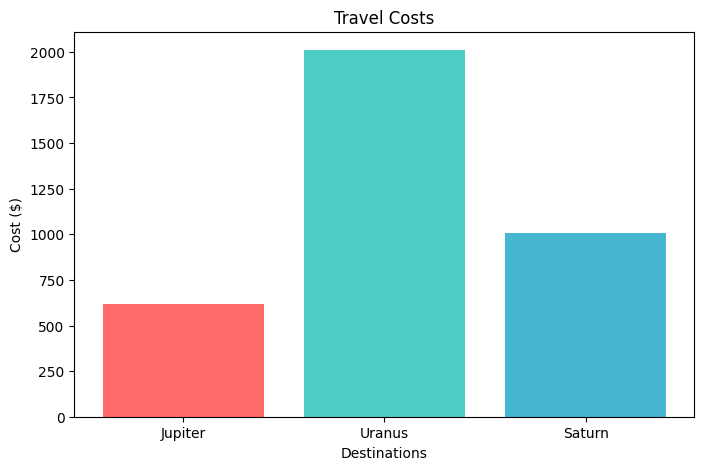

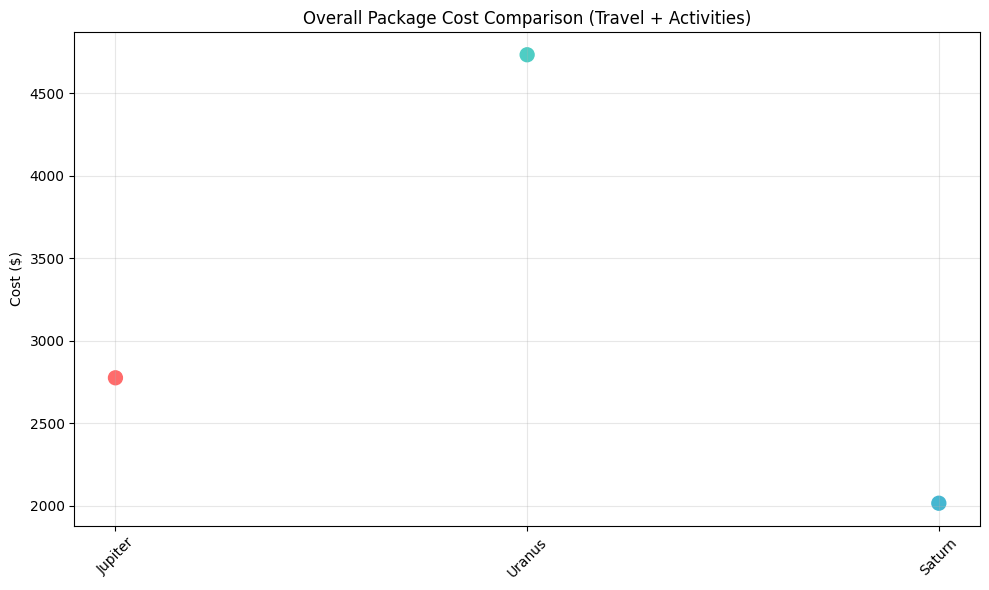


COMPARING TOUR EFFICIENCY
Most Cost-Efficient Tour: Saturn at $200.0 per AU.
Total Package Cost: $2014.0


In [122]:
# Plotting Comparison Figures
print("\n" + "="*80)
print("Generating Visualizations...")
print("="*80)

# Call plot_travel_costs to plot prices of traveling for trip.
plot_travel_costs(selected_destinations, user_goals)

if len(packages) < 3:
    print(" Package Comparison Skipped ")
    print(f"ERROR: Only {len(packages)} out of 3 tour packages were successfully created.")
    print("Please check the brochure files with 'ERROR:' in them to see which LLM outputs failed parsing.")
else:
    # Plot the new total costs plot with the corrected function
    plot_total_costs(packages)

    # Utilizing the TourComparisonTool for Added Technical Depth
    print("\n" + "="*80)
    print("COMPARING TOUR EFFICIENCY")
    print("="*80)

    # Create an instance of the new comparison class
    comparison_tool = TourComparisonTool(packages)

    # Use the comparison method
    efficiency_report = comparison_tool.find_most_cost_efficient()
    print(efficiency_report)

**Conclusions and Discussion**
--

### Results Interpretation and Conclusions


- Our project relies on LLM API calls to select the 3 destinations out of our predetermined list of 8 to suggest to the customer/user as well as suggesting 3 activities included in each tour package for that location.

- The LLM will also output prices for each activity.

- Although there were some issues with token amount and LLM output, overall, the outputs produced were what we were hoping for, which were whimsical and general activities very loosely based in the reality of the conditions in each location.

- Our intended output was 3 files each representing a brochure for each of the chosen 3 destination and we acheived this using claude LLM API, custom classes, and matplotlib.

### LLM Limitations, Mistakes, Surprises, etc


- The LLM sometimes failed to follow format instructions.

- It often struggled to generate the correct number of items (e.g., three activities).

- In some runs, the system heavily relied on fallback options.

- This required us to modify and stricten the prompting.

- We also had to make the prompts more versatile.

- When a token limit was enforced, the LLM sometimes cut a sentence off mid-word.

- It would be better if the LLM had shortened the sentence instead of truncating it.

- This suggests an issue with its token management strategy.

These are examples of limitations and unexpected behaviors. We tried to add few shot and structured LLM prompting to help fix these.

### Individual Contribution Statements

- Vivian Wang debugged code, added Markdown text sections, fixed coding errors.

- Anshula Agolla worked on LLM integration and debugging.

- Rory Conrad worked on MatPlot and graphs.
